<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"><li><span><a href="#Intro" data-toc-modified-id="Intro-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Intro</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load Data</a></span></li><li><span><a href="#Setup-Super-Resolution" data-toc-modified-id="Setup-Super-Resolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup Super-Resolution</a></span></li><li><span><a href="#Cyclical-Feeding" data-toc-modified-id="Cyclical-Feeding-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Cyclical Feeding</a></span><ul class="toc-item"><li><span><a href="#TODOs" data-toc-modified-id="TODOs-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>TODOs</a></span></li></ul></li><li><span><a href="#Image-Sharpening" data-toc-modified-id="Image-Sharpening-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Image Sharpening</a></span></li><li><span><a href="#Source-Data-FaceSwap-and-Upscaling" data-toc-modified-id="Source-Data-FaceSwap-and-Upscaling-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Source Data FaceSwap and Upscaling</a></span></li></ul></div>

# Intro
Notebook exploring random experiments around the use of the trained Faceswap generators.

In [138]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
import sys
import pickle
import yaml

import cv2

from tqdm import tqdm

# Plotting
%matplotlib notebook
%matplotlib inline

sns.set_context("paper")
sns.set_style("dark")

sys.path.append('../face_swap')

from utils import image_processing

from face_swap import faceswap_utils as utils
from face_swap import FaceGenerator, FaceDetector
from face_swap import gan, gan_utils
from face_swap import CONFIG_PATH
from face_swap.Face import Face

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
data_folder = Path.home() / "Documents/datasets/"
models_folder = Path.home() / "Documents/models/"

# Load Data

In [ ]:
with open(str(data_folder / "cifar-10-batches-py" / "data_batch_1"), 'rb') as fo:
    cifar = pickle.load(fo, encoding='bytes')

In [ ]:
cifar_img = np.rollaxis(cifar[b'data'][3].reshape(3, 32, 32), 0, 3)
cifar_img.shape

In [ ]:
img = cv2.imread(str(data_folder / "cat-pet-animal-domestic-104827.jpeg"))

In [ ]:
plt.imshow(cifar_img)
plt.show()

In [ ]:
# Load two random celeba faces
from_face_img = cv2.cvtColor(cv2.imread(str(data_folder / "img_align_celeba" / 
                            "000{}{}{}.jpg".format(*np.random.randint(0, 9, 3)))),
                             cv2.COLOR_BGR2RGB)
to_face_img = cv2.cvtColor(cv2.imread(str(data_folder / "img_align_celeba" / 
                          "000{}{}{}.jpg".format(*np.random.randint(0, 9, 3)))),
                       cv2.COLOR_BGR2RGB)

In [ ]:
plt.imshow(from_face_img)
plt.show()
plt.imshow(to_face_img)
plt.show()

# Setup Super-Resolution

In [140]:
from utils import super_resolution

In [141]:
config = {
    'models_path' : str(models_folder / "super_resolution/v1"),
    'LR_IMG_SHAPE' : "(64, 64, 3)"
}

In [142]:
sr_model = super_resolution.get_SRResNet(config)

/Users/amartinelli/Documents/python_workspace/data-science-learning/utils/super_resolution.py:81: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (3, 3), activation="linear", padding="same")`
  outp = Convolution2D(3, (3, 3), activation='linear', border_mode='same')(x)


Loading Super Resolution Models...
Super Resolution Models Loaded


In [143]:
def get_hr_version(sr_model, lr_img):
    hr_image = sr_model.predict(np.asarray([lr_img/255.0]))[0]
    hr_image = np.clip(hr_image * 255, 0, 255).astype(np.uint8)
    return hr_image

In [172]:
face_img = cv2.imread("/Users/amartinelli/Documents/datasets/faceswap_experiments/cycle_feed/02/_0099.png")

In [161]:
to_face = get_hr_version(sr_model, cv2.resize(face_img, (64, 64)).astype(np.uint8))

In [187]:
tmp_face = Face(face_img, face_img)

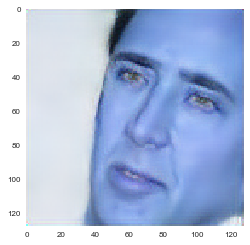

In [231]:
plt.imshow(crop(tmp_face.face_img, 0))
plt.show()

In [183]:
tmp_face.face_img = zoom(tmp_face.face_img)

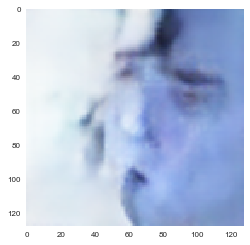

In [184]:
plt.imshow(generator.generate(tmp_face)[0])
plt.show()

# Cyclical Feeding
Cycling feeding own output to generator. Can start with actual face or random noise. 

## TODOs
* Try apply text on image before feeding to generator

In [226]:
def crop(img, crop_factor=0.2):
    h, w = img.shape[:2]
    h_crop = int((h * crop_factor)//2)
    w_crop = int((w * crop_factor)//2)
    return img[h_crop:h-h_crop, w_crop:w-w_crop]

In [220]:
def zoom(img, zoom_factor=1.5):
    h, w = img.shape[:2]
    mat = cv2.getRotationMatrix2D((w//2, h//2), 0, zoom_factor)
    #mat[:, 2] -= (w//2, h//2)
    result = cv2.warpAffine(img, mat, (w, h), borderMode=cv2.BORDER_REPLICATE)
    return result

In [215]:
# load config
with open(CONFIG_PATH, 'r') as ymlfile:
    cfg = yaml.load(ymlfile)
model_cfg = cfg['masked_gan']['v1']

In [207]:
# load generator and related functions
gen_a, gen_b, _, _ = gan.get_gan(model_cfg, load_discriminators=False)
_, _, _, fun_generate_a, fun_mask_a, fun_abgr_a = gan_utils.cycle_variables_masked(gen_a)
_, _, _, fun_generate_b, fun_mask_b, fun_abgr_b = gan_utils.cycle_variables_masked(gen_b)

Loading GAN Models...
GAN Models Loaded


In [208]:
gen_fun_a = lambda x: fun_abgr_a([np.expand_dims(x, 0)])[0][0]
gen_fun_b = lambda x: fun_abgr_b([np.expand_dims(x, 0)])[0][0]

In [209]:
generator_a = FaceGenerator.FaceGenerator(
            lambda face_img: FaceGenerator.gan_masked_generate_face(gen_fun_a, face_img),
            input_size=(64, 64), tanh_fix=True)
generator_b = FaceGenerator.FaceGenerator(
            lambda face_img: FaceGenerator.gan_masked_generate_face(gen_fun_b, face_img),
            input_size=(64, 64), tanh_fix=True)

In [216]:
gen_input = Face(img, img)
use_a = True
generator = generator_a if use_a else generator_b
for i in range(500):
    out = get_hr_version(sr_model, generator.generate(gen_input, (64, 64))[0])
    #out = generator.generate(gen_input, (128, 128))[0]
    gen_input.face_img = FaceGenerator.random_transform(out, **cfg['random_transform'])
    #gen_input.img = zoom(out)
    res_path = str(data_folder / 'faceswap_experiments/cycle_feed/02/_{:04d}.png'.format(i))
    #cv2.imwrite(res_path, zoom(out))
    cv2.imwrite(res_path, out)
    # swap generator randomly every epoch
    #generator = generator_a if np.random.rand() > 0.5 else generator_b
    # swap generator every N epoch
    if i%50 == 0:
        use_a = not use_a
        generator = generator_a if use_a else generator_b

In [241]:
sum(sr_model.output_shape[1:3])

256

In [171]:
%%bash
WORKDIR=/Users/amartinelli/Documents/datasets/faceswap_experiments/cycle_feed
ffmpeg -i ${WORKDIR}/02/_%04d.png -vf "fps=12,format=yuv420p" ${WORKDIR}/out_$(date +%s).mp4

/bin/sh: ffmpeg: command not found


# Image Sharpening

In [ ]:
# adapted from https://github.com/AdityaPokharel/Sharpen-Image
regular_kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
edge_enhance_kernel = np.array([[-1,-1,-1,-1,-1],
                               [-1,2,2,2,-1],
                               [-1,2,8,2,-1],
                               [-2,2,2,2,-1],
                               [-1,-1,-1,-1,-1]])/8.0
def sharpen(img, kernel=regular_kernel):
    # apply kernel to input image
    res = cv2.filter2D(img, -1, kernel)
    return res

In [ ]:
plt.imshow(sharpen(to_face_img))
plt.show()

# Source Data FaceSwap and Upscaling
Try to cherry pick some results of face-swapping on the training data, apply upscaling to a reasonable size (e.g. 128x128) and any possible post-processing that might help in improving image quality.


In [ ]:
input_path = data_folder / "facesets/cage"
out_path = data_folder / "faceswap_experiments/source_faceswap/cage_trump"

out_size = (64, 64)

In [ ]:
# collected all image paths
img_paths = image_processing.get_imgs_paths(input_path, as_str=False)

# iterate over all collected image paths
for i, img_path in enumerate(img_paths):
    img = cv2.imread(str(img_path))
    gen_input = Face(img, img)
    gen_face = generator_b.generate(gen_input)[0]
    gen_face = sharpen(gen_face)
    gen_face = cv2.resize(gen_face, out_size)
    cv2.imwrite(str(out_path / "out_{:04d}.jpg".format(i)),
                            gen_face)